In [1]:
%load_ext autoreload
%autoreload 2

In [231]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from ipywidgets import interact
from scipy.optimize import curve_fit
from matplotlib import patches
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage.metrics import peak_signal_noise_ratio as psnr

from datafusion.ffusion import FusionAdam
from datafusion.baseline import baseline
from datafusion.utils import mono_exponential_decay_numpy as decay
from datafusion.utils import (
    RESOURCES_PATH,
    FIGURES_PATH,
    spectral_volume_to_color,
    time_volume_to_lifetime,
    linear_to_srgb,
    wavelength_to_srgb,
    sam,
)

XY_DIM = 128
Z_START = 10
Z_END = 11

CELLS_PATH = RESOURCES_PATH / "cells.npz"
CELLS_ZOOM_PATH = RESOURCES_PATH / "cells_zoom.npz"

TAU = r"$\tau$"

In [232]:
cells = np.load(CELLS_PATH)
cells_zoom = np.load(CELLS_ZOOM_PATH)

# CMOS loading
cmos = cells["cmos"]
cmos = np.transpose(cmos, (1, 2, 0))
cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, cmos.shape[2]))
cmos = np.transpose(cmos, (2, 1, 0))
cmos = cmos[Z_START:Z_END]

# SPC loading
spc = cells["spc"]
gt_spc = cells_zoom["spc"]
# FIXME: Replace with correct [0,0] pixel.
gt_spc[:, :, 0, 0] = gt_spc[:, :, 1, 0]

# Time axis loading
t = cells["time_axis"]
dt = t[1] - t[0]

# Wavelength axis loading
lam = cells["spectral_axis"]

metadata = cells["metadata"]
print(metadata)

[['laser' '520nm']
 ['dichroic' '550nm']
 ['filter' '550nm']
 ['spectrometer' '610nm']
 ['time_bin_size' '200ps']
 ['time_axis' 'ns']
 ['spectral_axis' 'nm']
 ['compression_ratio' '0.5']
 ['inversion' 'TVAL3_b5m8']
 ['time_cut' 'at peak']
 ['slide_info' 'Mouse Kidney F24630 FluoCells Invitrogen']]


In [233]:
initial_spectrums = np.sum(spc, axis=0)
min_spectrums, max_spectrums = np.min(initial_spectrums), np.max(initial_spectrums)

initial_times = np.sum(spc, axis=1)
min_times, max_times = np.min(initial_times), np.max(initial_times)

resolution_diff_factor = int(cmos.shape[-1] / spc.shape[-1])
normalized_cmos = cmos / cmos.max()

def spc_spectrum_time_in_a_point(cmos_z=5, spc_i=19, spc_j=17):
    _, ax = plt.subplots(2, 3, figsize=(9, 6))
    ax[0, 0].imshow(normalized_cmos[cmos_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].scatter([spc_j * resolution_diff_factor], [spc_i * resolution_diff_factor], c="w")
    ax[0, 0].set_title(f"CMOS in Z={cmos_z}")

    ax[1, 0].imshow(spectral_volume_to_color(lam, spc.sum(axis=0)[:, np.newaxis])[0])
    ax[1, 0].scatter([spc_j], [spc_i], c="w")
    ax[1, 0].set_title(f"SPC Spectrum Colored")

    ax[0, 1].plot(lam, spc.sum(axis=(0, 2, 3)))
    ax[0, 1].set_title(f"Global spectrum - {len(lam)} channels")
    ax[0, 1].set_xlabel("Wavelength [nm]")
    ax[0, 1].grid()

    ax[0, 2].plot(t, spc.sum(axis=(1, 2, 3)))
    ax[0, 2].set_title(f"Global time decay - {len(t)} temporal points")
    ax[0, 2].set_xlabel("Time [ns]")
    ax[0, 2].grid()

    ax[1, 1].plot(lam, initial_spectrums[:, spc_i, spc_j])
    ax[1, 1].set_ylim(min_spectrums, max_spectrums)
    ax[1, 1].set_title(f"Spectrum in ({spc_i},{spc_j})")
    ax[1, 1].set_xlabel("Wavelength [nm]")
    ax[1, 1].grid()

    ax[1, 2].plot(t, initial_times[:, spc_i, spc_j])
    ax[1, 2].set_ylim(min_times, max_times)
    ax[1, 2].set_title(f"Time in ({spc_i},{spc_j})")
    ax[1, 2].set_xlabel("Time [ns]")
    ax[1, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    spc_spectrum_time_in_a_point,
    cmos_z=(0, cmos.shape[0] - 1, 1),
    spc_i=(0, spc.shape[-2] - 1, 1),
    spc_j=(0, spc.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=0, description='cmos_z', max=0), IntSlider(value=19, description='spc_i'…

  0%|          | 0/800 [00:00<?, ?it/s]

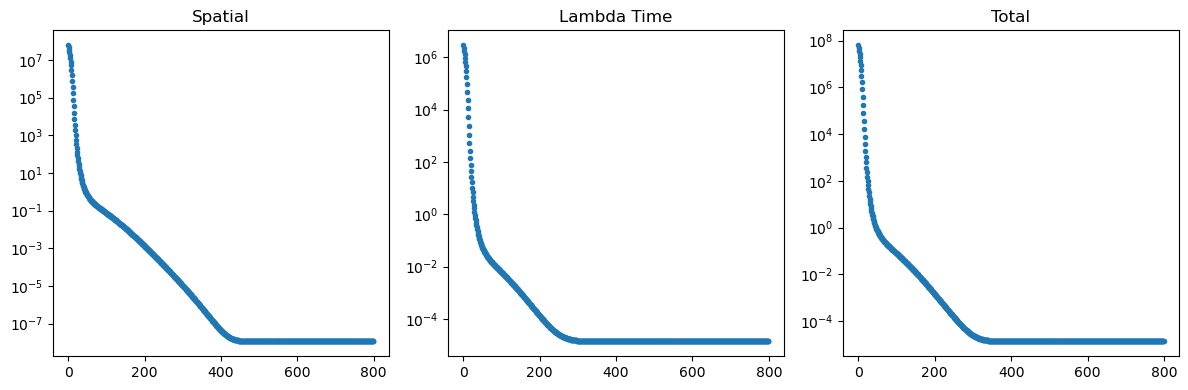

In [246]:
weights = {
    "spatial": 0.5,
    "lambda_time": 0.5,
    # "global": 0.0,
}

fusion = FusionAdam(
    spc, cmos,
    time_axis=t,
    weights=weights,
    init_type="simple",
    mask_noise=False,
    tol=1e-7,
    total_energy=1,
    device="mps",
    seed=42,
)

x, spc_out, cmos_out, x_fit = fusion(max_iterations=800, lr=5e-2, return_numpy=True)

In [248]:
slices_rgb = spectral_volume_to_color(lam, np.sum(x, axis=0))
slices_rgb_spc = spectral_volume_to_color(lam, spc_out[:, :, np.newaxis, :, :].sum(axis=0))[0]

spectrums = np.sum(x, axis=(0, 3, 4)).T
times = np.sum(x, axis=(1, 3, 4)).T


def plot_across_z(z=10, i=80, j=70):
    _, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax[0, 0].imshow(slices_rgb_spc)
    ax[0, 0].scatter([j // 4], [i // 4], c="w")
    ax[0, 0].set_title(f"SPC")

    ax[1, 1].plot(lam, spectrums[z])
    ax[1, 1].set_ylim(spectrums.min(), spectrums.max())
    ax[1, 1].set_title(f"Global Spectrum in z={z}")
    ax[1, 1].grid()

    ax[1, 2].plot(t, times[z])
    ax[1, 2].set_ylim(times.min(), times.max())
    ax[1, 2].set_title(f"Global Time in z={z}")
    ax[1, 2].grid()

    reconstructed_spectrums = np.sum(x[:, :, z, :, :], axis=0)
    lxy_spc = np.sum(spc_out, axis=0)

    reconstructed_times = np.sum(x[:, :, z, :, :], axis=1)
    txy_spc = np.sum(spc_out, axis=1)

    ax[1, 0].imshow(slices_rgb[z])
    ax[1, 0].scatter([j], [i], c="w")
    ax[1, 0].set_title(f"Reconstruction Spectral Colored z={z}")

    ax[0, 1].plot(lam, reconstructed_spectrums[:, i, j] * 1 * 16, label="DF")
    ax[0, 1].plot(lam, lxy_spc[:, i // 4, j // 4], label="SPC")
    ax[0, 1].set_title(f"Spectrum in ({i},{j})")
    ax[0, 1].legend(loc="upper right")
    ax[0, 1].grid()

    params, covariance = curve_fit(
        decay,
        t,
        reconstructed_times[:, i, j] / reconstructed_times[:, i, j].max(),
        bounds=([0.0, 1e-6, 0.0], [1, 6.0, 0.1]),
        p0=(0.5, 2.0, 0.00001),
        maxfev=5000,
    )
    a, tau, c = params

    ax[0, 2].plot(t, txy_spc[:, i // 4, j // 4] / txy_spc[:, i // 4, j // 4].max(), label="SPC", c="C1")
    ax[0, 2].scatter(t, reconstructed_times[:, i, j] / reconstructed_times[:, i, j].max(), label="DF", c="C0",
                     marker="+")
    ax[0, 2].plot(t, decay(t, a, tau, c), label=f"DF Fit {TAU}: {tau:.2f} ns", c="C0")
    ax[0, 2].set_title(f"Time in ({i},{j})")
    ax[0, 2].legend(loc="upper right")
    ax[0, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    plot_across_z,
    z=(0, x.shape[2] - 1, 1),
    i=(0, x.shape[-2] - 1, 1),
    j=(0, x.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=0, description='z', max=0), IntSlider(value=80, description='i', max=127…

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

SAM: 0.18 rad


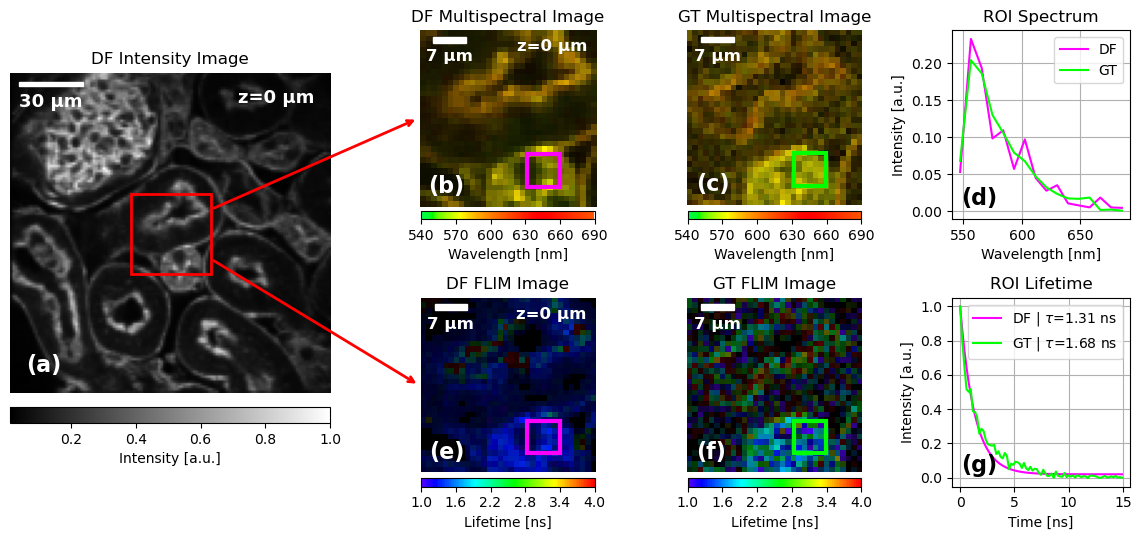

In [249]:
def add_z_text(z_index, ax, font_size=12):
    ax.text(
        0.95, 0.95, f"z={z_index} µm",
        transform=ax.transAxes,
        fontsize=font_size,
        fontweight="bold",
        va="top",
        ha="right",
        c="w"
    )


def plot_zoom_results(
        x, t, lam,
        gt_spc,
        z_index,
        zoom_slice=slice(48, 80),
        roi_u=slice(24, 30),
        roi_v=slice(19, 25),
        font_size_letters=16,
        tau_clip=(0, 4),
        save_name=None,
):
    # Defining spectral colorbar
    wavelengths_ticks = np.arange(540, 691, 1)
    spectral_colors = wavelength_to_srgb(wavelengths_ticks, "basic").T
    spectral_colors = linear_to_srgb(spectral_colors)
    spectral_colors /= spectral_colors.max(axis=1)[..., np.newaxis]
    spectral_cmap = LinearSegmentedColormap.from_list("spectrum", spectral_colors, N=len(wavelengths_ticks))

    # Defining fused scalebar
    fused_micro_width = 150  # in micrometers
    pixel_size = fused_micro_width / x.shape[-1]
    scalebar_length_micrometers = 30
    scalebar_length_pixels = scalebar_length_micrometers / pixel_size

    # Defining zoomed scalebar
    zoomed_micro_width = 150 / (x.shape[-1] / gt_spc.shape[-1])
    pixel_size = zoomed_micro_width / gt_spc.shape[-1]
    scalebar_length_micrometers_zoomed = 7
    scalebar_length_pixels_zoomed = scalebar_length_micrometers_zoomed / pixel_size

    fused_intensity = x.sum(axis=(0, 1))[z_index]

    # Defining the fused zoomed tensors
    fused_zoomed = x[:, :, z_index:z_index + 1, zoom_slice, zoom_slice]
    fused_zoomed_spectral = spectral_volume_to_color(lam, fused_zoomed.sum(axis=0))[0]
    fused_lifetime_image = time_volume_to_lifetime(
        t, fused_zoomed.sum(axis=1), tau_clip=tau_clip, noise_thr=0.1
    )[0][0]

    # Defining the ground truth zoomed tensors
    gt_spc_spectral = spectral_volume_to_color(lam, gt_spc.sum(axis=0)[:, np.newaxis])[0]
    ground_truth_lifetime_image = time_volume_to_lifetime(
        t, gt_spc.sum(axis=1, keepdims=True), tau_clip=tau_clip, noise_thr=0.1
    )[0][0]

    # fused_zoomed_time_wavelength = fused_zoomed.sum(axis=(2, 3))[:, :, 0]
    # gt_time_wavelength = gt_spc.sum(axis=(2, 3))
    # psnr_time_wavelength = psnr(gt_time_wavelength, fused_zoomed_time_wavelength,
    #                             data_range=gt_time_wavelength.max() - gt_time_wavelength.min())
    # print(f"PSNR time-wavelength: {psnr_time_wavelength:.2f} dB")

    fig = plt.figure(figsize=(11.5, 5.5))
    gs = fig.add_gridspec(2, 4, width_ratios=[1.8, 1, 1, 1], height_ratios=[1, 1])

    # Plot fused intensity
    ax0 = fig.add_subplot(gs[:, 0])
    fused_0 = ax0.imshow(fused_intensity / fused_intensity.max(), cmap='gray')
    ax0.set_title(f"DF Intensity Image")
    ax0.add_patch(patches.Rectangle(
        (zoom_slice.start, zoom_slice.start),
        zoom_slice.stop - zoom_slice.start,
        zoom_slice.stop - zoom_slice.start,
        linewidth=2, edgecolor='red', facecolor='none')
    )
    ax0.text(0.05, 0.05, "(a)", transform=ax0.transAxes, fontsize=font_size_letters, fontweight='bold', va='bottom',
             c="w")
    scalebar = AnchoredSizeBar(
        ax0.transData,
        scalebar_length_pixels,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers} µm',  # Label for the scalebar
        'upper left',
        pad=0.4,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1.5,
        fontproperties={"size": 13, "weight": "bold"},
    )
    ax0.add_artist(scalebar)
    add_z_text(z_index, ax0, font_size=13)

    # ax0.text(
    #     0.48, 0.06, f"PSNR: {psnr_intensity:.2f} dB",
    #     transform=ax0.transAxes,
    #     fontsize=12,
    #     va="top",
    #     color="white",
    #     fontweight="bold",
    # )

    ax0.axis("off")

    # Spectral comparison
    ax01 = fig.add_subplot(gs[0, 1])
    zoom01 = ax01.imshow(fused_zoomed_spectral, cmap=spectral_cmap)
    ax01.set_title(f"DF Multispectral Image")
    ax01.text(0.05, 0.05, "(b)", transform=ax01.transAxes, fontsize=font_size_letters,
              fontweight='bold', va='bottom', c="w")
    ax01.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="magenta", facecolor='none')
    )
    scalebar = AnchoredSizeBar(
        ax01.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax01.add_artist(scalebar)
    add_z_text(z_index, ax01, font_size=12)

    # Add PSNR with respect to the ground truth
    # psnr_spectrum = np.zeros(gt_spc.shape[1])
    # for i in range(gt_spc.shape[1]):
    #     gt_tmp = gt_spc.sum(axis=0)[i]
    #     fused_tmp = fused_zoomed.sum(axis=0)[i, 0]
    #     psnr_spectrum[i] = psnr(
    #         gt_tmp,
    #         fused_tmp,
    #         data_range=gt_tmp.max() - gt_tmp.min(),
    #     )
    # print(psnr(gt_spc.sum(axis=(0, 1)), fused_zoomed.sum(axis=(0, 1))[0],
    #            data_range=gt_spc.sum(axis=(0, 1)).max() - gt_spc.sum(axis=(0, 1)).min()))
    # psnr_lifetime = np.mean(psnr_spectrum)
    # ax01.text(
    #     0.26, 0.08, f"PSNR: {psnr_lifetime:.2f} dB",
    #     transform=ax01.transAxes,
    #     fontsize=10,
    #     va="top",
    #     color="white",
    #     fontweight="bold",
    # )
    ax01.axis("off")

    ax02 = fig.add_subplot(gs[0, 2])
    zoom02 = ax02.imshow(gt_spc_spectral, cmap=spectral_cmap)
    ax02.set_title(f"GT Multispectral Image")
    ax02.text(0.05, 0.05, "(c)", transform=ax02.transAxes, fontsize=font_size_letters, fontweight='bold', va='bottom',
              c="w")
    ax02.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="lime", facecolor='none')
    )
    scalebar = AnchoredSizeBar(
        ax02.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax02.add_artist(scalebar)
    ax02.axis("off")

    ax03 = fig.add_subplot(gs[0, 3])
    fused_roi_spectrum = fused_zoomed[:, :, 0, roi_u, roi_v].sum(axis=(0, 2, 3))
    fused_roi_spectrum /= fused_roi_spectrum.sum()
    ax03.plot(lam, fused_roi_spectrum, label="DF", c="magenta")
    spc_roi_spectrum = gt_spc[:, :, roi_u, roi_v].sum(axis=(0, 2, 3))
    spc_roi_spectrum /= spc_roi_spectrum.sum()
    ax03.plot(lam, spc_roi_spectrum, label="GT", c="lime")
    ax03.set_title("ROI Spectrum")
    ax03.set_xlabel("Wavelength [nm]")
    ax03.set_ylabel("Intensity [a.u.]")
    ax03.legend()
    ax03.grid()
    ax03.text(0.05, 0.05, "(d)", transform=ax03.transAxes, fontsize=font_size_letters, fontweight="bold", va='bottom')
    print(f"SAM: {sam(fused_roi_spectrum, spc_roi_spectrum):.2F} rad")

    # Lifetime comparison
    hsv_colormap = np.vstack([np.linspace(0, 26 / 36, 100)[::-1], np.ones(100), np.ones(100)]).T
    lifetime_cmap = LinearSegmentedColormap.from_list("fused_lifetime", hsv_to_rgb(hsv_colormap), N=100)

    ax11 = fig.add_subplot(gs[1, 1])
    zoom11 = ax11.imshow(fused_lifetime_image, cmap=lifetime_cmap)
    ax11.set_title(f"DF FLIM Image")
    ax11.text(0.05, 0.05, "(e)", transform=ax11.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom",
              c="w")
    ax11.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="magenta", facecolor='none'))
    scalebar = AnchoredSizeBar(
        ax11.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax11.add_artist(scalebar)
    add_z_text(z_index, ax11, font_size=12)

    # Add PSNR with respect to the ground truth
    # psnr_lifetime = psnr(gt_spc_tau, fused_zoomed_tau, data_range=gt_spc_tau.max() - gt_spc_tau.min())
    # ax11.text(
    #     0.26, 0.08, f"PSNR: {psnr_lifetime:.2f} dB",
    #     transform=ax11.transAxes,
    #     fontsize=10,
    #     va="top",
    #     color="white",
    #     fontweight="bold",
    # )

    ax11.axis("off")

    ax12 = fig.add_subplot(gs[1, 2])
    zoom12 = ax12.imshow(ground_truth_lifetime_image, cmap=lifetime_cmap)
    ax12.set_title(f"GT FLIM Image")
    ax12.text(0.05, 0.05, "(f)", transform=ax12.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom",
              c="w")
    ax12.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="lime", facecolor='none'))
    scalebar = AnchoredSizeBar(
        ax12.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        sep=5,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax12.add_artist(scalebar)
    ax12.axis("off")

    ax13 = fig.add_subplot(gs[1, 3])
    fused_roi_time = fused_zoomed[:, :, 0, roi_u, roi_v].sum(axis=(1, 2, 3))
    fused_roi_time /= fused_roi_time.max()
    params, _ = curve_fit(decay, t, fused_roi_time,
                          bounds=([0.0, 1e-6, 0.0], [1, 6.0, 0.1]),
                          p0=(0.5, 2.0, 0.000001),
                          maxfev=5000,
                          )
    ax13.plot(t, fused_roi_time, label=f"DF | {TAU}={params[1]:.2F} ns", c="magenta")
    spc_roi_time = gt_spc[:, :, roi_u, roi_v].sum(axis=(1, 2, 3))
    spc_roi_time /= spc_roi_time.max()
    params, _ = curve_fit(decay, t, spc_roi_time,
                          bounds=([0.0, 1e-6, 0.0], [1, 6.0, 0.1]),
                          p0=(0.5, 2.0, 0.000001),
                          maxfev=5000,
                          )
    ax13.plot(t, spc_roi_time, label=f"GT | {TAU}={params[1]:.2F} ns", c="lime")
    ax13.legend()
    ax13.set_title("ROI Lifetime")
    ax13.set_xlabel("Time [ns]")
    ax13.set_ylabel("Intensity [a.u.]")
    # ax13.set_yscale("log")
    ax13.grid()
    ax13.text(0.05, 0.05, "(g)", transform=ax13.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom")

    # Spectral color bars
    fig.colorbar(fused_0, ax=ax0, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")
    cbar = fig.colorbar(zoom01, ax=ax01, fraction=0.046, pad=0.02, orientation="horizontal", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(wavelengths_ticks[::30])))
    cbar.set_ticklabels([f"{w:.0f}" for w in wavelengths_ticks[::30]])

    cbar = fig.colorbar(zoom02, ax=ax02, fraction=0.046, pad=0.03, orientation="horizontal", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(wavelengths_ticks[::30])))
    cbar.set_ticklabels([f"{w:.0f}" for w in wavelengths_ticks[::30]])

    # Lifetime color bars
    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=lifetime_cmap), ax=ax11, fraction=0.046, pad=0.03,
                        orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_clip[0], tau_clip[1], 6)])

    cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=lifetime_cmap), ax=ax12, fraction=0.046, pad=0.03,
                        orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 6))
    cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_clip[0], tau_clip[1], 6)])

    ax0.annotate(
        "", xy=(-0.01, 0.5), xytext=(zoom_slice.stop, 54),
        xycoords=ax01.transAxes, textcoords="data",
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

    ax0.annotate(
        "", xy=(-0.01, 0.5), xytext=(zoom_slice.stop, 74),
        xycoords=ax11.transAxes, textcoords="data",
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

    plt.tight_layout()

    if save_name:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)

    plt.show()


plot_zoom_results(
    x, t, lam, gt_spc,
    z_index=0,
    zoom_slice=slice(48, 80),
    # Normal ROI
    save_name="results_kidney2_normal_roi_fit.pdf",
    roi_u=slice(22, 28),
    roi_v=slice(19, 25),
    # Hard ROI
    # save_name="results_kidney2_hard_roi_fit.pdf",
    # roi_u=slice(6, 12),
    # roi_v=slice(22, 28),
    # One pixel ROI
    # roi_u=slice(20, 21),
    # roi_v=slice(15, 16),
    font_size_letters=16,
    tau_clip=(1, 4),
)